In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.base import TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_regression

from scipy.stats import entropy

%matplotlib inline

# Класс дискретизации по принципу деления по медиане

In [2]:
class MedianBinarizer(TransformerMixin):
    def __init__(self, n_bins: int):
        self.n_bins = n_bins
        self.x_bins = None
    
    def _get_feature_bins(self, X):
        iterations = np.log2(self.n_bins)
        if iterations - int(iterations) != 0:
            raise Exception('bins should be a power of 2')
        
        # получаем вариационный ряд
        x_bins = [np.sort(X)]
        for i in range(int(iterations)):
            new_bins = list()
            for j in x_bins:
                # середина среза вариационного ряда
                index = j.shape[0] // 2
                new_bins += [j[:index], j[index:]]
            x_bins = new_bins
        return x_bins
    
    def _lookup(self, x):
        for k, _bin in enumerate(self.x_bins):
            if x in _bin:
                return k
        return -1

    
    def _real_to_category(self, X):
        # X should not be a column vector
        X_new = []
        for x in X:
            i = self._lookup(x)
            if i != -1:
                X_new.append(i)
            else:
                raise Exception('something went wrong')

        return np.array(X_new).reshape(-1, 1)
    
    def fit(self, X):
        self.x_bins = self._get_feature_bins(X)
    
    def transform(self, X):
        encoder = OneHotEncoder()
        X_cat = self._real_to_category(X)

        return X_cat, encoder.fit_transform(X_cat)
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [3]:
def synchronize_counts(_from: dict, _to: dict):
    subset = np.setdiff1d(list(_from.keys()), list(_to.keys()))
    for i in subset:
        _to[i] = 0

In [44]:
def cross_entropy(p, q):
    p = np.array(p)
    q = np.array(q)
    q[q == 0] = 0.0001
    return -np.sum(p * np.log(q))

# Дискретизированные переменные имеют равномерное распределение

In [5]:
binarizer = MedianBinarizer(32)

In [87]:
result = binarizer.fit_transform(np.random.lognormal(size=1000))[0]

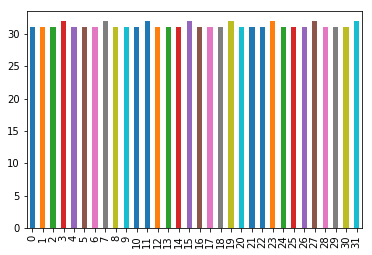

In [88]:
pd.Series(result.squeeze()).value_counts().sort_index().plot.bar()

In [89]:
X, y, coefs = make_regression(n_samples=10000, n_features=20, n_informative=4, coef=True)

In [90]:
feature_space = []
for i in range(X.shape[1]):
    binarizer = MedianBinarizer(32)
    feature_space.append(binarizer.fit_transform(X[:, i].squeeze()))

In [92]:
np.random.seed(42)
initial_feature = np.random.randint(0, len(feature_space))

dataset_size = X.shape[0]
free_features = [i for i in range(len(feature_space)) if i != initial_feature]
subset = [initial_feature]

while len(subset) != len(feature_space):
    max_entropy = -1
    feature_index = -1
    
    print('#'*100)
    for ix_feature, feature in enumerate(free_features):
        if len(subset) > 1:
            input_features = np.concatenate([feature_space[i][1].todense() for i in subset], axis=1)
        else:
            input_features = feature_space[subset[0]][1]
        
        reg = LogisticRegression()
        reg.fit(input_features, feature_space[feature][0].squeeze())
        predicted = reg.predict(input_features)
        
        pred_category, pred_counts = np.unique(predicted, return_counts=True)
        real_category, real_counts = np.unique(feature_space[feature][0], return_counts=True)
        
        pred_proba = pred_counts / dataset_size
        real_proba = real_counts / dataset_size
        
        real_stats = dict(zip(real_category, real_proba))
        pred_stats =  dict(zip(pred_category, pred_proba))
        
        synchronize_counts(real_stats, pred_stats)
        
        ce_r_r = cross_entropy(list(real_stats.values()), list(real_stats.values()))
        ce_p_p = cross_entropy(list(pred_stats.values()), list(pred_stats.values()))
        ce_r_p = cross_entropy(list(real_stats.values()), list(pred_stats.values()))
        
        if max_entropy < ce_r_p:
            max_entropy = ce_r_p
            feature_index = ix_feature
        
        print('-'*25,feature,'-'*25)
        print('cross-entropy real, real', ce_r_r)
        print('cross-entropy pred, pred', ce_p_p)
        print('cross-entropy real, pred', ce_r_p)
    
    subset.append(free_features[feature_index])
    del free_features[feature_index]
    
print('generated ordered list of variables')
print(subset)
print('real informative variables')
print(np.argwhere(coefs > 0).squeeze())

####################################################################################################
------------------------- 0 -------------------------
cross-entropy real, real 3.4657346227991805
cross-entropy pred, pred 2.999786124404508
cross-entropy real, pred 5.062399954410142
------------------------- 1 -------------------------
cross-entropy real, real 3.4657346227991805
cross-entropy pred, pred 2.97289986897186
cross-entropy real, pred 5.211369763619523
------------------------- 2 -------------------------
cross-entropy real, real 3.4657346227991805
cross-entropy pred, pred 2.913102367009418
cross-entropy real, pred 5.378022657930959
------------------------- 3 -------------------------
cross-entropy real, real 3.4657346227991805
cross-entropy pred, pred 2.8783166110326572
cross-entropy real, pred 5.256824361532612
------------------------- 4 -------------------------
cross-entropy real, real 3.4657346227991805
cross-entropy pred, pred 3.0160708933314306
cross-entropy real, p